In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

In [386]:
del training_data
training_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Reset ID column as Index

In [387]:
training_data.set_index('Id',inplace=True)
test_data.set_index('Id',inplace=True)

In [388]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

The first thing you will notice is that the data is composed of both numerical and categorical features. In order to perform linear regression on the categorical data, we will need to convert it to binary features using one hot encoding. 

Before we get to that, we must clean and process the data.

# Some Preliminary data exploration:

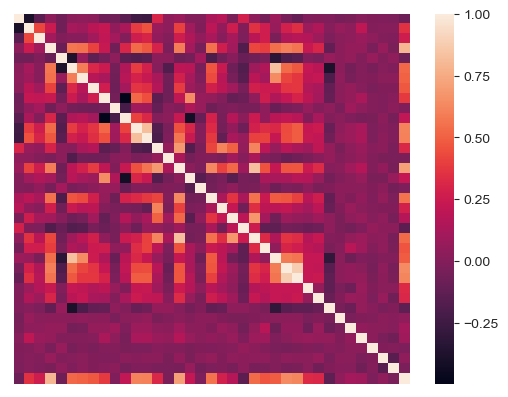

In [389]:
sns.heatmap(training_data.corr(),xticklabels=False,yticklabels=False)

A heatmap of correlations between numerical featuers. This suggests a lot of cross correlation in the features, which hints at using an algorith that can deal with cross correlation such as Lasso Regression.
Next we take a quick look at the top features correlated with Sale Price.

In [390]:
training_data.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Looking at the cross-correlations between the top variables correlated with Sale Price:

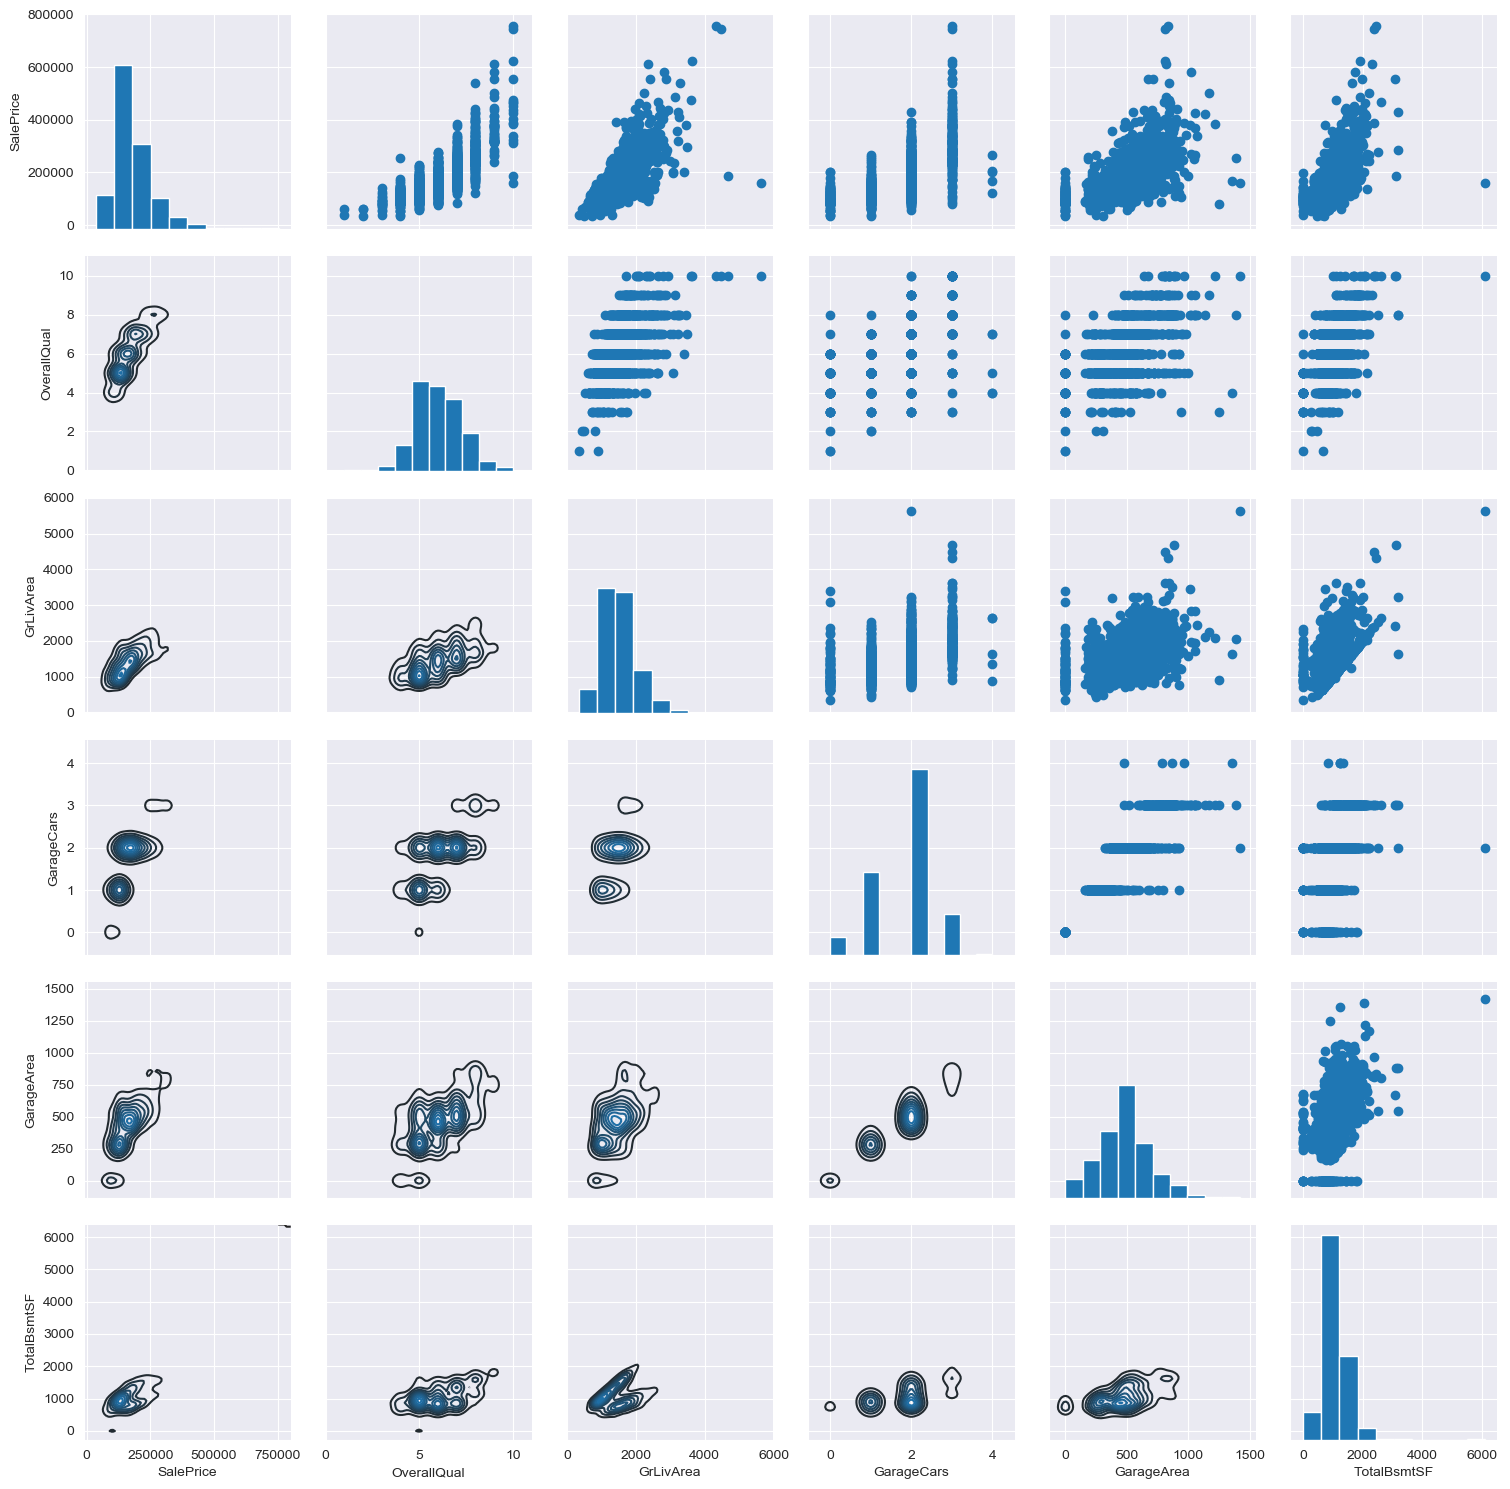

In [391]:
g=sns.PairGrid(data=training_data,vars=training_data.corr()['SalePrice'].sort_values(ascending=False).nlargest(6).index)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

# Filling Null Values

The data description usually tells us what the null values should be filled as.

In [303]:
training_data['Alley'].fillna(value='NoAlley',inplace=True)
training_data['LotFrontage'].fillna(value=0,inplace=True)
training_data['GarageType'].fillna(value='NoGarage',inplace=True)
training_data['Fence'].fillna(value='NoFence',inplace=True)
training_data['MasVnrType'].fillna(value='None',inplace=True)
training_data['MasVnrArea'].fillna(value=0,inplace=True)
training_data['BsmtQual'].fillna('No',inplace=True)
training_data['BsmtCond'].fillna('No',inplace=True)
training_data['BsmtExposure'].fillna('No',inplace=True)
training_data['BsmtFinType1'].fillna('No',inplace=True)
training_data['BsmtFinType2'].fillna('No',inplace=True)
training_data['FireplaceQu'].fillna('No',inplace=True)
training_data['GarageFinish'].fillna('No',inplace=True)
training_data['GarageQual'].fillna('No',inplace=True)
training_data['GarageCond'].fillna('No',inplace=True)
training_data['PoolQC'].fillna('No',inplace=True)
training_data['MiscFeature'].fillna('No',inplace=True)
training_data['GarageYrBlt'].fillna(training_data['YearBuilt'],inplace=True)
#training_data['Electrical'].fillna('SBrkr',inplace=True)

Do the same for test data, but with a few more features containing nulls.

In [304]:
test_data['Alley'].fillna(value='NoAlley',inplace=True)
test_data['LotFrontage'].fillna(value=0,inplace=True)
test_data['GarageType'].fillna(value='NoGarage',inplace=True)
test_data['Fence'].fillna(value='NoFence',inplace=True)
test_data['MasVnrType'].fillna(value='None',inplace=True)
test_data['MasVnrArea'].fillna(value=0,inplace=True)
test_data['BsmtQual'].fillna('No',inplace=True)
test_data['BsmtCond'].fillna('No',inplace=True)
test_data['BsmtExposure'].fillna('No',inplace=True)
test_data['BsmtFinType1'].fillna('No',inplace=True)
test_data['BsmtFinType2'].fillna('No',inplace=True)
test_data['FireplaceQu'].fillna('No',inplace=True)
test_data['GarageFinish'].fillna('No',inplace=True)
test_data['GarageQual'].fillna('No',inplace=True)
test_data['GarageCond'].fillna('No',inplace=True)
test_data['PoolQC'].fillna('No',inplace=True)
test_data['MiscFeature'].fillna('No',inplace=True)
test_data['GarageYrBlt'].fillna(test_data['YearBuilt'],inplace=True)

test_data['Utilities'].fillna('AllPub',inplace=True)
test_data['BsmtFinSF1'].fillna(0,inplace=True)
test_data['BsmtFinSF2'].fillna(0,inplace=True)
test_data['BsmtUnfSF'].fillna(0,inplace=True)
test_data['TotalBsmtSF'].fillna(0,inplace=True)
test_data['BsmtFullBath'].fillna(0,inplace=True)
test_data['BsmtHalfBath'].fillna(0,inplace=True)
test_data['Functional'].fillna(8,inplace=True)
test_data['KitchenQual'].fillna(3,inplace=True)
test_data['SaleType'].fillna('WD',inplace=True)
test_data['GarageCars'].fillna(0,inplace=True)
test_data['Exterior1st'].fillna('VinylSd',inplace=True)
test_data['Exterior2nd'].fillna('VinylSd',inplace=True)
test_data['GarageArea'].fillna(0,inplace=True)
test_data['MSZoning'].fillna('RL',inplace=True)

In [132]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
MSSubClass       1459 non-null object
MSZoning         1459 non-null object
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1459 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1459 non-null object
Exterior2nd      145

The Ames dataset description says that a few outliers with very large GrLivArea have strange behavior and suggests culling them, so that is what we will do.

In [305]:
training_data[(training_data['GrLivArea']>4000) & (training_data['SalePrice']<200000)]
training_data.drop(index=[523,1298],inplace=True)
training_data.dropna(subset=['Electrical'],inplace=True)

In [306]:
training_data.isnull().sum().sum()

0

In [307]:
test_data.isnull().sum().sum()

0

# Data type conversions

Taking a look at one of the categorical features, "Functional". In the data description, this is defined as home functionality, with a wide range of values of broke-downedness.

Typ  Typical Functionality

   Min1 Minor Deductions 1
   
   Min2 Minor Deductions 2
   
   Mod  Moderate Deductions
   
   Maj1 Major Deductions 1
   
   Maj2 Major Deductions 2
   
   Sev  Severely Damaged
   
   Sal  Salvage only
   
   
   These seem to exist on a scale from Perfect Condition to an absolute disaster that is only good for the raw materials that can be salvaged from it. 

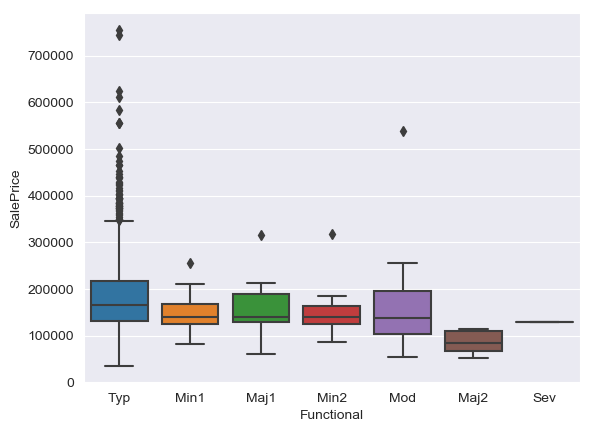

In [4]:
plt.style.use('default')
sns.set_style('darkgrid')
sns.boxplot(x='Functional',y='SalePrice',data=training_data)

Instead of letting it multiply into 7 different binary features, we can convert this to a numerical scale.

In [308]:
training_data['Functional'].replace({'Sal':0,'Sev':1,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},inplace=True)

Upon inspection, the same is true for many of the other categorical features. Many of them can be converted with the same dictionary.

In [309]:
ExQuD={'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
training_data['ExterQual'].replace(ExQuD,inplace=True)
training_data['ExterCond'].replace(ExQuD,inplace=True)
training_data['BsmtQual'].replace(ExQuD,inplace=True)
training_data['BsmtCond'].replace(ExQuD,inplace=True)
training_data['BsmtExposure'].replace({'No':0,'Mn':1,'Av':2,'Gd':3},inplace=True)
training_data['HeatingQC'].replace(ExQuD,inplace=True)
training_data['CentralAir'].replace({'Y':1,'N':0},inplace=True)
training_data['KitchenQual'].replace(ExQuD,inplace=True)
training_data['GarageFinish'].replace({'No':0,'Unf':1,'RFn':2,'Fin':3},inplace=True)
training_data['GarageQual'].replace(ExQuD,inplace=True)
training_data['GarageCond'].replace(ExQuD,inplace=True)
training_data['PavedDrive'].replace({'N':0,'P':1,'Y':2},inplace=True)
training_data['PoolQC'].replace(ExQuD,inplace=True)
training_data['Fence'].replace({'NoFence':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4},inplace=True)
training_data['FireplaceQu'].replace(ExQuD,inplace=True)

test_data['ExterQual'].replace(ExQuD,inplace=True)
test_data['ExterCond'].replace(ExQuD,inplace=True)
test_data['BsmtQual'].replace(ExQuD,inplace=True)
test_data['BsmtCond'].replace(ExQuD,inplace=True)
test_data['BsmtExposure'].replace({'No':0,'Mn':1,'Av':2,'Gd':3},inplace=True)
test_data['HeatingQC'].replace(ExQuD,inplace=True)
test_data['CentralAir'].replace({'Y':1,'N':0},inplace=True)
test_data['KitchenQual'].replace(ExQuD,inplace=True)
test_data['Functional'].replace({'Sal':0,'Sev':1,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},inplace=True)
test_data['FireplaceQu'].replace(ExQuD,inplace=True)
test_data['GarageFinish'].replace({'No':0,'Unf':1,'RFn':2,'Fin':3},inplace=True)
test_data['GarageQual'].replace(ExQuD,inplace=True)
test_data['GarageCond'].replace(ExQuD,inplace=True)
test_data['PavedDrive'].replace({'N':0,'P':1,'Y':2},inplace=True)
test_data['PoolQC'].replace(ExQuD,inplace=True)
test_data['Fence'].replace({'NoFence':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4},inplace=True)

In [88]:
#training_data['BsmtFinType1'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)
#training_data['BsmtFinType2'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)
#test_data['BsmtFinType1'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)
#test_data['BsmtFinType2'].replace({'No':0,'Rec':1,'BLQ':2,'LwQ':3,'ALQ':4,'Unf':5,'GLQ':6},inplace=True)

Conversely, the feature MSSubClass is encoded as a number, but actually describes completely separate categories of house type. We wil convert this numerical feature into a categorical one.

In [310]:

training_data['MSSubClass'].replace({20 : "1-STORY 1946 & NEWER ALL STYLES", 30 : "1-STORY 1945 & OLDER", 
                                     40 : "1-STORY W/FINISHED ATTIC ALL AGES", 45 : "1-1/2 STORY - UNFINISHED ALL AGES", 
                                     50 : "1-1/2 STORY FINISHED ALL AGES", 60 : "2-STORY 1946 & NEWER",
                                     70 : "2-STORY 1945 & OLDER", 75 : "2-1/2 STORY ALL AGES", 
                                     80 : "SPLIT OR MULTI-LEVEL", 85 : "SPLIT FOYER",
                                     90 : "DUPLEX - ALL STYLES AND AGES", 
                                     120 : "1-STORY PUD (Planned Unit Development) - 1946 & NEWER", 
                                     150 : "1-1/2 STORY PUD - ALL AGES", 
                                     160 : "2-STORY PUD - 1946 & NEWER",
                                     180 : "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER", 
                                     190 : "2 FAMILY CONVERSION - ALL STYLES AND AGES"},inplace=True)

test_data['MSSubClass'].replace({20 : "1-STORY 1946 & NEWER ALL STYLES", 30 : "1-STORY 1945 & OLDER", 
                                     40 : "1-STORY W/FINISHED ATTIC ALL AGES", 45 : "1-1/2 STORY - UNFINISHED ALL AGES", 
                                     50 : "1-1/2 STORY FINISHED ALL AGES", 60 : "2-STORY 1946 & NEWER",
                                     70 : "2-STORY 1945 & OLDER", 75 : "2-1/2 STORY ALL AGES", 
                                     80 : "SPLIT OR MULTI-LEVEL", 85 : "SPLIT FOYER",
                                     90 : "DUPLEX - ALL STYLES AND AGES", 
                                     120 : "1-STORY PUD (Planned Unit Development) - 1946 & NEWER", 
                                     150 : "1-1/2 STORY PUD - ALL AGES", 
                                     160 : "2-STORY PUD - 1946 & NEWER",
                                     180 : "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER", 
                                     190 : "2 FAMILY CONVERSION - ALL STYLES AND AGES"},inplace=True)


# Concatenating Train and Test Data 
(For the next couple manipulations)

In [311]:
training_data.shape

(1457, 80)

In [312]:
test_data.shape

(1459, 79)

In [313]:
data=pd.concat([training_data.drop('SalePrice',axis=1),test_data])

# Looking at Gaussian skew

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


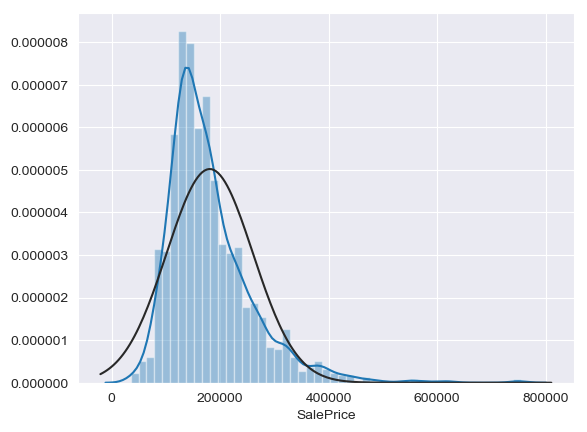

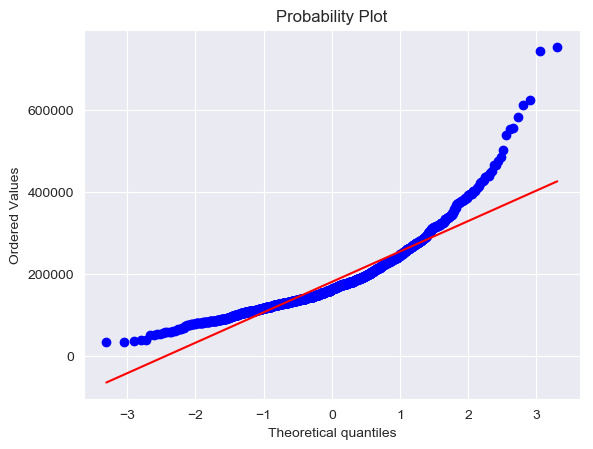

In [36]:
sns.distplot(training_data['SalePrice'],fit=norm)
fig = plt.figure()
res = stats.probplot(training_data['SalePrice'], plot=plt)

On Visual inspection, we can see that Sale Price does not have a perfectly normal distribution. It is skewed to the right. We can confirm this further with a Q-Q plot.

In [314]:
skew(training_data['SalePrice'])

1.8778593479363705

Try log transformation:

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


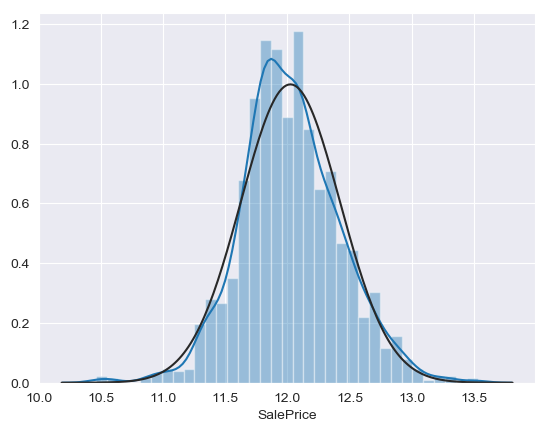

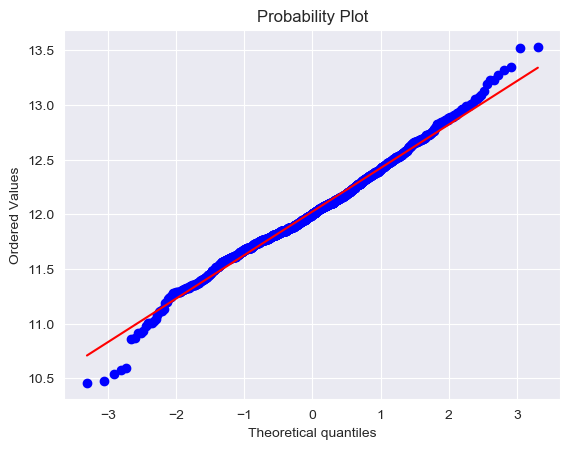

In [260]:
sns.distplot(np.log(training_data['SalePrice']),fit=norm)
fig = plt.figure()
res = stats.probplot(np.log(training_data['SalePrice']), plot=plt)

The result is a more normal distribution. We will use the common rule of thumb and apply this transformation to all features with greater than 0.5 skew. Many of them contain zero, so we must use log1p = log(x + 1)

In [315]:
training_data['SalePrice']=np.log(training_data['SalePrice'])

In [316]:
num_features=test_data.select_dtypes(exclude=object).columns
num_features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [317]:
skewed=[]
for col in num_features:
    if abs(skew(data[col]))>0.5:
        data[col]=np.log1p(data[col])
        skewed.append(col)
        latestfeat= col
skewed

'YrSold'

In [318]:
skewed

['LotArea',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal']

In [319]:
len(skewed)

38

# One-hot / get dummies transformation

In [320]:
onehot_data=pd.get_dummies(data)
onehot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 1 to 2919
Columns: 257 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(42), int64(9), uint8(206)
memory usage: 1.7 MB


Re-split into training and test

In [321]:
X_test=onehot_data.iloc[1457:]
X=onehot_data.iloc[:1457]
y=training_data['SalePrice']

In [322]:
X_test.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.910212,9.078854,6.078821,1.865037,7.586866,1983.662783,2.038185,1.472533,1.403556,1.462499,...,0.002056,0.080192,0.002742,0.86292,0.061001,0.005483,0.008225,0.017820,0.825223,0.082248
std,32.266054,0.501942,1.436812,0.177850,0.015481,21.130467,2.613299,0.129306,0.093887,0.301373,...,0.045314,0.271683,0.052306,0.34405,0.239414,0.073871,0.090348,0.132344,0.379907,0.274837
min,0.000000,7.293698,1.000000,0.693147,7.539027,1950.000000,0.000000,1.098612,0.693147,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,8.908154,5.000000,1.791759,7.577634,1963.000000,0.000000,1.386294,1.386294,1.386294,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,63.000000,9.148465,6.000000,1.791759,7.587817,1992.000000,0.000000,1.386294,1.386294,1.386294,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,78.000000,9.351710,7.000000,1.945910,7.601902,2004.000000,5.093750,1.609438,1.386294,1.609438,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,200.000000,10.943782,10.000000,2.302585,7.606387,2010.000000,7.163172,1.791759,1.791759,1.791759,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
y.describe()

count    1457.000000
mean       12.024005
std         0.399853
min        10.460242
25%        11.774520
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

# Training the Linear Regression

# Lasso Regression

To find alpha: First search in logspace, than a more fine grain search in linear space.

In [323]:
alphas = np.logspace(-4,3,15)
#alphas = np.linspace(2.5e-4,3.5e-4,11)
alphas

array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [341]:
lasso=LassoCV(cv=5,alphas=alphas).fit(X,y)
print('Converged to an alpha of '+str(lasso.alpha_)+'.')
print('Lasso has reduced the original features to ' + str(sum(lasso.coef_!=0)) + 
      ' features out of ' + str(len(lasso.coef_)))
y_pred=lasso.predict(X)
print('R Score: '+str(lasso.score(X,y)))
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error(np.log(y),
                        np.log(y_pred)))))

Converged to an alpha of 0.00031622776601683794.
Lasso has reduced the original features to 119 features out of 257
R Score: 0.9322730407431158
RMSE of the log: 0.008738481281314794


Looking at the resulting Coefficients:

In [325]:
cdf = pd.DataFrame(lasso.coef_,X.columns,columns=['Coeff'])
cdf.sort_values('Coeff',ascending=False)

,Coeff
GrLivArea,0.381468
OverallCond,0.204328
Functional,0.189958
Neighborhood_StoneBr,0.124289
Neighborhood_NridgHt,0.100039
RoofMatl_WdShngl,0.098878
Neighborhood_Crawfor,0.095514
Neighborhood_NoRidge,0.093034
LotArea,0.073070
Exterior1st_BrkFace,0.064108


In [343]:
final_answers=lasso.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,116660.032940
1462,159189.578658
1463,180171.300094
1464,198885.492864
1465,208091.543395


In [344]:
sub.to_csv('submission4.csv')

# Elastic Net

In [106]:
from sklearn.linear_model import ElasticNetCV

In [356]:
alphas = np.logspace(-4,3,15)
l1_ratio=[.1, .5, .7, .9, .95, .99, 1]
elastic=ElasticNetCV(cv=5,alphas=alphas,l1_ratio=l1_ratio).fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

In [358]:
print('Converged to an alpha of '+str(elastic.alpha_)+'.')
print('Converged to an l1 ratio of '+str(elastic.l1_ratio_)+'.')
print('Lasso has reduced the original features to ' + str(sum(elastic.coef_!=0)) + 
      ' features out of ' + str(len(elastic.coef_)))
y_pred=elastic.predict(X)
print('R Score (training data): '+str(elastic.score(X,y)))
print('RMSE of the log (training data): ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

Converged to an alpha of 0.00031622776601683794.
Converged to an l1 ratio of 1.0.
Lasso has reduced the original features to 119 features out of 257
R Score (training data): 0.9322730407431158
RMSE of the log (training data): 0.1040189618465261


RMSE of the log (test data): 0.12231 (from kaggle)

# Bayesian Ridge Regression

In [328]:
from sklearn.linear_model import BayesianRidge

In [329]:
bayes=BayesianRidge().fit(X,y)

In [359]:
print('Estimated precision of noise: '+str(bayes.alpha_)+'.')
print('Estimated precision of weights '+str(bayes.lambda_)+'.')
y_pred=bayes.predict(X)
print('R Score: '+str(bayes.score(X,y)))
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

Estimated precision of noise: 81.67722648955183.
Estimated precision of weights 313.0834560375674.
R Score: 0.9319393485593727
RMSE of the log: 0.10427489881237015


RMSE of the log (test data): 0.12323

# Automatic Relevance Determination

In [332]:
from sklearn.linear_model import ARDRegression

In [333]:
ARD = ARDRegression().fit(X,y)

In [360]:
print('Estimated precision of noise: '+str(ARD.alpha_)+'.')
print('Estimated precision of weights '+str(ARD.lambda_)+'.')
y_pred=ARD.predict(X)
print('R Score: '+str(ARD.score(X,y)))
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

Estimated precision of noise: 88.87078294279817.
Estimated precision of weights [3.95867873e+05 1.91303412e+02 4.40306658e+02 1.22939878e+01
 1.03685308e-01 3.47917198e+05 1.25030301e+05 6.58412078e+04
 3.46463030e+04 1.10309029e+02 2.60663175e+05 8.12258630e+02
 1.04662591e+04 4.98564477e+05 4.98740998e+04 9.26821427e+01
 1.93394378e+02 2.54132630e+02 1.00440999e+05 1.11540228e+05
 2.83683567e+04 6.02038847e+00 1.37208016e+02 2.50304777e+04
 3.13200372e+03 1.03620082e+03 3.57358173e+04 2.98220764e+01
 1.06353304e+03 1.95029174e+04 2.32690933e+01 5.74951809e+02
 4.98769826e+05 4.57117962e+05 1.46607485e+04 3.71137964e+02
 1.04099177e+05 2.29027356e+04 1.36684419e+05 1.01145219e+04
 8.62257666e+04 2.13109564e+05 2.68293045e+05 3.61038336e+04
 1.31457898e+04 2.06608368e+04 8.16068079e+01 5.01002056e+04
 1.06345898e+05 2.47637178e+05 7.99191919e+04 1.66310636e+04
 1.08349895e+04 1.00000000e+00 1.43251253e+05 2.44283928e+03
 4.27279518e+04 9.09092258e+03 2.39878745e+04 1.66113004e+04
 1.42

In [335]:
final_answers=ARD.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,111992.513702
1462,156923.232198
1463,174933.891515
1464,190546.802156
1465,197672.311173


In [336]:
sub.to_csv('submission5.csv')

RMSE of the log (test data), from Kaggle: 0.12940
The training error went down while the test error went up. overfitting perhaps.

# Ensemble Methods

In [337]:
from sklearn import ensemble

In [338]:
from sklearn.ensemble import GradientBoostingRegressor

In [353]:
GBR = GradientBoostingRegressor(loss='huber').fit(X,y)

In [361]:
y_pred=GBR.predict(X)
print('RMSE of the log: ' + str(np.sqrt(metrics.mean_squared_error((y),
                        (y_pred)))))

RMSE of the log: 0.0884374632838561


In [355]:
final_answers=GBR.predict(X_test)
sub = pd.DataFrame({'Id':X_test.index,'SalePrice':final_answers})
sub.set_index('Id',inplace=True)
sub=np.exp(sub)
sub.head()

,SalePrice
Id,
1461,122009.808087
1462,163874.348590
1463,180776.676781
1464,184915.831661
1465,193705.505760


In [352]:
sub.to_csv('submission7.csv')

RMSE of the log (test data, from kaggle): 0.13454
An even more marked split between training and test error. Need to further tinker with this algorithm to address overfitting.